Random Forest
==========================

## Pre Feature Engineering
First, we will run the data through a basic model. Then, we will apply feature engineering and a rolling forecast to try to enhance the model's performance as much as possible.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [ ]:
# Data Preprocessing
df = pd.read_csv('CSV/Anchorage_weather_5_years_weekly.csv', parse_dates=['Date'], index_col='Date')

# Filter data to train on data up to the end of 2021 and test on 2022
train_df = df[df.index.year < 2022]
test_df = df[df.index.year == 2022]

X_train = train_df.drop('Temperature_Max', axis=1)
y_train = train_df['Temperature_Max']
X_test = test_df.drop('Temperature_Max', axis=1)
y_test = test_df['Temperature_Max']

# Model Fitting
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Prediction and Evaluation
y_pred = model.predict(X_test)
mse = round(mean_squared_error(y_test, y_pred), 2)
rmse = round(sqrt(mse), 2)
print(f'Mean Squared Error: {mse}')

# Create a DataFrame to hold the actual and predicted values, indexed by date
result_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
}, index=y_test.index)

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(result_df.index, result_df['Actual'], label='Actual')
plt.plot(result_df.index, result_df['Predicted'], label='Predicted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Max Temperature')
plt.title(f'Random Forest: Actual vs Predicted Max Temperature for 2022, Root Mean Squared Error: {rmse} degrees Fahrenheit')
plt.legend()
plt.show()

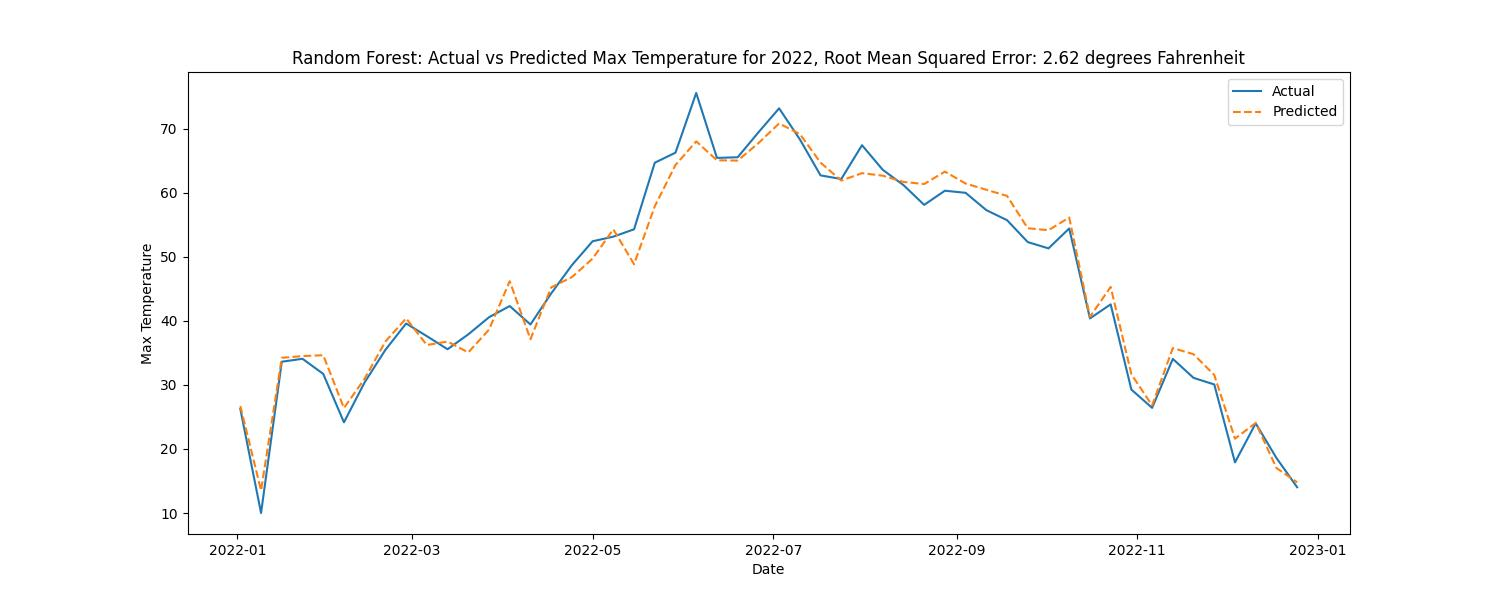

Already, we are achieving a much better RMSE. However, the graph could be plotted more effectively. We will use the rolling forecast method to address this issue. But first, let's explore feature engineering.

## Feature Engineering Testing
We will use feature engineering to create new features that, hopefully, will improve the model's predictive power. Let's set up a script to assess the importance of each feature.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [ ]:
# Data Preprocessing
df = pd.read_csv('CSV/Anchorage_weather_5_years_weekly.csv', parse_dates=['Date'], index_col='Date')

# Uncomment each engineered feature one at a time to evaluate its effectiveness
df['Temp_Precip'] = df['Temperature_Max'] * df['Precipitation']
df['Temp_Snowfall'] = df['Temperature_Max'] * df['Snowfall']
df['Temp_Windspeed'] = df['Temperature_Max'] * df['Windspeed']
df['Temp_Max_Min'] = df['Temperature_Max'] * df['Temperature_Min']

# Handle missing values if needed
# df.dropna(inplace=True)

# Data Splitting
X = df.drop('Temperature_Max', axis=1)
y = df['Temperature_Max']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Fitting
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Prediction and Evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Feature Importance
feature_importances = model.feature_importances_
feature_names = X_train.columns
feature_dict = dict(zip(feature_names, feature_importances))
sorted_features = {k: v for k, v in sorted(feature_dict.items(), key=lambda item: item[1], reverse=True)}

print("Feature importances:")
for feature, importance in sorted_features.items():
    print(f"{feature}: {importance}")

In [ ]:
Temp_Precip
Mean Squared Error: 10.904469971320784
Feature importances:
Temperature_Min: 0.9754782287267357
Precipitation: 0.008159443047110169
Temp_Precip: 0.007580421803280666
Windspeed: 0.00692190456821754
Snowfall: 0.0018600018546559114

Temp_Snowfall
Mean Squared Error: 10.74270794641509
Feature importances:
Temperature_Min: 0.9754545009086945
Precipitation: 0.014628592565123286
Windspeed: 0.007393483134695992
Temp_Snowfall: 0.0013398888007017475
Snowfall: 0.0011835345907844545

Temp_Windspeed
Mean Squared Error: 10.217864490943422
Feature importances:
Temperature_Min: 0.9721057614582588
Precipitation: 0.013627608123632642
Temp_Windspeed: 0.008010106778120064
Windspeed: 0.0046626963731231
Snowfall: 0.0015938272668654277

Temp_Max_Min
Mean Squared Error: 4.814414220754709
Feature importances:
Temp_Max_Min: 0.962340337030819
Temperature_Min: 0.031490910295339056
Precipitation: 0.0031273770473391254
Windspeed: 0.0025307207393370492
Snowfall: 0.0005106548871658001

All features
Mean Squared Error: 4.961112553773592
Feature importances:
Temp_Max_Min: 0.9669617072722445
Temperature_Min: 0.025223405306874187
Temp_Windspeed: 0.002629677615279862
Temp_Precip: 0.0017122914815227593
Precipitation: 0.0015319200740528196
Windspeed: 0.001439115499691505
Temp_Snowfall: 0.0002563726923740325
Snowfall: 0.0002455100579603693

It looks like the Temp_Max_Min feature has the highest feature importance. Additionally, we can see that the MSE is actually higher when we use all the features. So, let's just stick with the 'Temp_Max_Min' feature.

## Rolling Forcast

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from math import sqrt

In [ ]:
# Data Preprocessing
df = pd.read_csv('Anchorage_weather_5_years_weekly.csv', parse_dates=['Date'], index_col='Date')
df['Temp_Precip'] = df['Temperature_Max'] * df['Precipitation']
df['Temp_Snowfall'] = df['Temperature_Max'] * df['Snowfall']
df['Temp_Windspeed'] = df['Temperature_Max'] * df['Windspeed']
df['Temp_Max_Min'] = df['Temperature_Max'] * df['Temperature_Min']
df.dropna(inplace=True)

# Prepare training and test data
train_size = len(df) - 52  # last 52 weeks as test set, for example
X_train = df.iloc[:train_size].drop('Temperature_Max', axis=1).values
X_test = df.iloc[train_size:].drop('Temperature_Max', axis=1).values
y_train = df.iloc[:train_size]['Temperature_Max'].values
y_test = df.iloc[train_size:]['Temperature_Max'].values

# Initialize predictions list
y_pred = []

# Walk-forward validation: refit model for each new observation
for i in range(len(X_test)):
    model = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_leaf=2, min_samples_split=2,
                                  random_state=42)
    model.fit(X_train, y_train)
    single_pred = model.predict([X_test[i]])
    y_pred.append(single_pred[0])

    # Update the training set
    X_train = np.vstack([X_train, [X_test[i]]])
    y_train = np.append(y_train, y_test[i])

# Calculate MSE
mse = round(mean_squared_error(y_test, y_pred), 2)
rmse = round(sqrt(mse), 2)
print(f'Mean Squared Error: {mse}')

# Convert predictions to a pandas Series for plotting
y_pred_series = pd.Series(y_pred, index=df.iloc[train_size:].index)

# Plot
plt.figure(figsize=(15, 6))
plt.plot(df.iloc[train_size:].index, y_test, label='Actual in 2022', color='green')
plt.plot(df.iloc[train_size:].index, y_pred_series, label='Predicted for 2022', color='red')
plt.title(f'Random Forest: Actual vs Predicted Max Temperature for 2022, Root Mean Squared Error: {rmse} degrees Fahrenheit')
plt.xlabel('Date')
plt.ylabel('Max Temperature')
plt.legend()
plt.show()

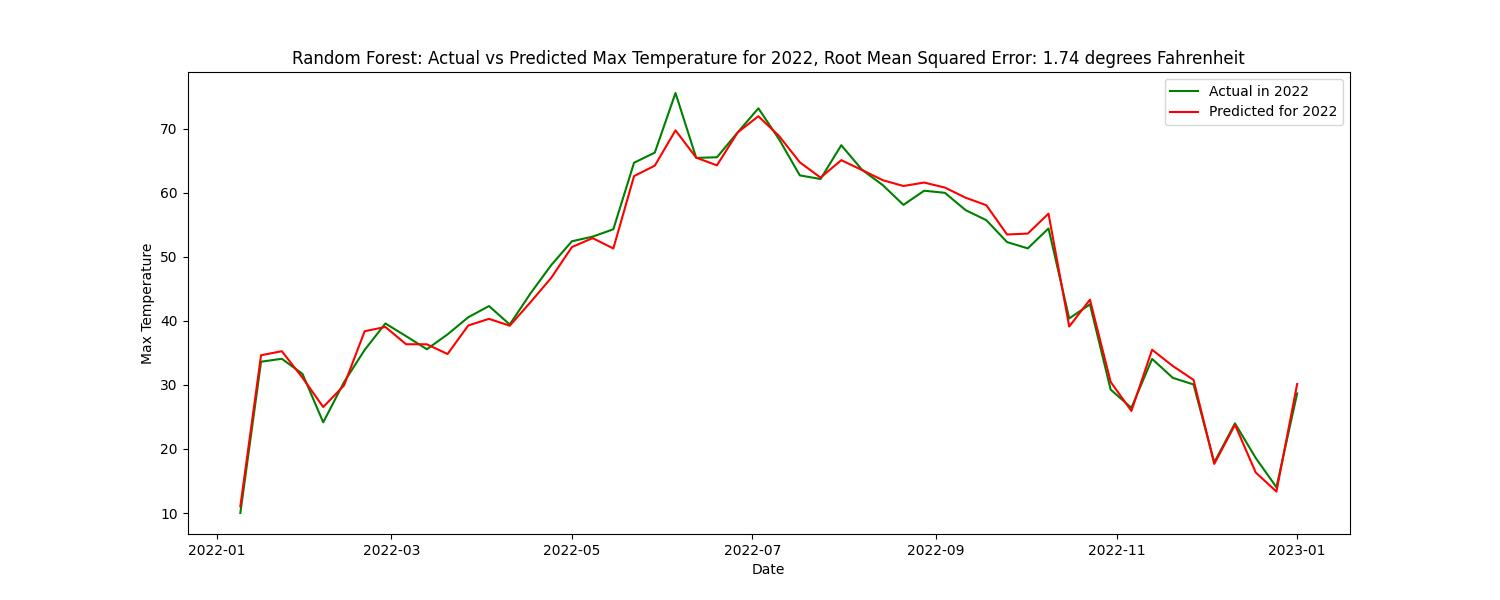

The forecast is almost perfectly fit to the actual data. I was afraid this fit too well so I ran Split Cross validation and  In-sample Out-sample validation to check for over fitting. But both came back negative. Let's move on to analyze the residuals to determine their level of normality.

## Residuals

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import shapiro
from _14_rolling_forcaast_forest_anchorage import y_test
from _14_rolling_forcaast_forest_anchorage import y_pred


In [ ]:
predictions = y_pred
residuals = y_test - predictions

# Graphical Methods
plt.figure(figsize=(12, 6))

# Residuals vs Predicted values
plt.subplot(1, 3, 1)
plt.scatter(predictions, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')

# Histogram of Residuals
plt.subplot(1, 3, 2)
plt.hist(residuals, bins=30)
plt.xlabel('Residuals')
plt.title('Histogram of Residuals')

# Time Series plot of Residuals
plt.subplot(1, 3, 3)
plt.plot(residuals)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Time Series Plot of Residuals')
plt.tight_layout()
plt.show()

# Numerical Methods
print(f"Mean of residuals: {np.mean(residuals)}")
print(f"Standard Deviation of residuals: {np.std(residuals)}")

# Shapiro-Wilk Test for normality
stat, p_value = shapiro(residuals)
print(f"Shapiro-Wilk Test P-value: {p_value}")


Mean Squared Error: 3.03
Mean of residuals: 0.029136961233210464
Standard Deviation of residuals: 1.7405012257287087
Shapiro-Wilk Test P-value: 0.1327473372220993

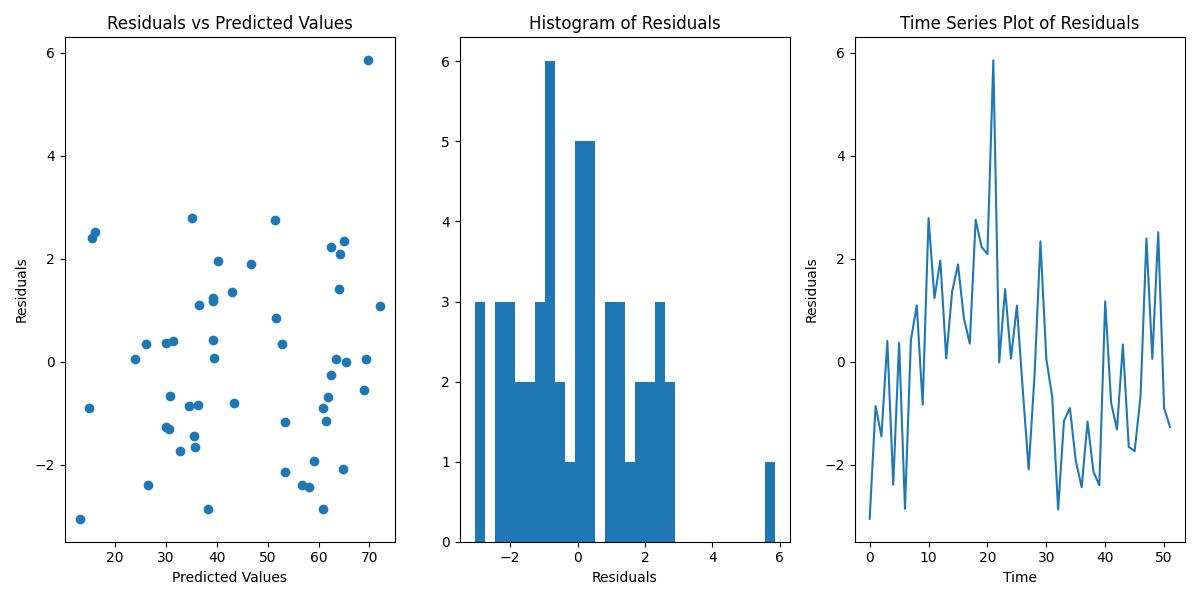

The residuals aren't too concerning. The p-value of 0.1327 is higher than the 0.05 threshold typically used to reject the null hypothesis of normality. Though the graph could definitely look more normal. It looks to also have a right skew to it with an outlier value. The time series plot, along withthe scatter plot, doesn't have a clear trend over time which is good. Though the graph may have some repetitive structures in it, suggesting possible autocorrelation. 

The model works much better than the SARIMA model. It seems to struggle in similar ways as the SARIMA model, but to a lesser extent. If we had used days instead of weeks the models may have worked better. Given computational limitations, this is the best we can achieve for now.